# Hand Gesture Recognition

importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torchvision import datasets
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from torchsummary import summary

Downloading the dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\datamunge\sign-language-mnist\versions\1


## American Sign Language (ASL) Alphabet

The image below displays the static hand gestures for the letters of the American Sign Language alphabet.

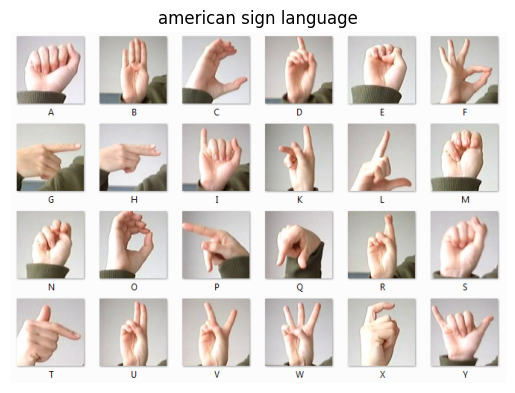

In [26]:
image_path = 'amer_sign2.png'

img = Image.open(image_path)
    
# Display the image
plt.imshow(img)
plt.title("american sign language")
plt.axis('off')
plt.show()

### the dataset includes letters A-Y but excludes J and Z, resulting in 24 classes.

In [27]:
train_csv_path = "dataset/sign_mnist_train/sign_mnist_train.csv"
test_csv_path = "dataset/sign_mnist_test/sign_mnist_test.csv"

# Load the dataset into a pandas DataFrame
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
# Count the number of unique values in the 'label' column
number_of_classes = train_df['label'].nunique()

print(f"Successfully loaded the data.")
print(f"Number of classes: {number_of_classes}")

train_samples = train_df.shape[0]
test_samples = test_df.shape[0]
total_samples = train_samples + test_samples

print(f"Training samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Total samples: {total_samples}")

Successfully loaded the data.
Number of classes: 24
Training samples: 27455
Test samples: 7172
Total samples: 34627


In [28]:
from sklearn.model_selection import train_test_split

y = test_df['label']
X = test_df.drop('label', axis=1)

# Split the data: 3500 samples for validation, the rest for the new test set
X_val, X_test_new, y_val, y_test_new = train_test_split(
    X, y,
    train_size=3500,
    random_state=42,
    stratify=y
)

validation_df = pd.concat([y_val, X_val], axis=1)
test_df_final = pd.concat([y_test_new, X_test_new], axis=1)


print(f"Shape of new validation set: {validation_df.shape}")
print(f"Shape of new final test set: {test_df_final.shape}")

# Check the range of labels in your data
print(f"Train labels min: {train_df['label'].min()}, max: {train_df['label'].max()}")
print(f"Validation labels min: {validation_df['label'].min()}, max: {validation_df['label'].max()}")

Shape of new validation set: (3500, 785)
Shape of new final test set: (3672, 785)
Train labels min: 0, max: 24
Validation labels min: 0, max: 24


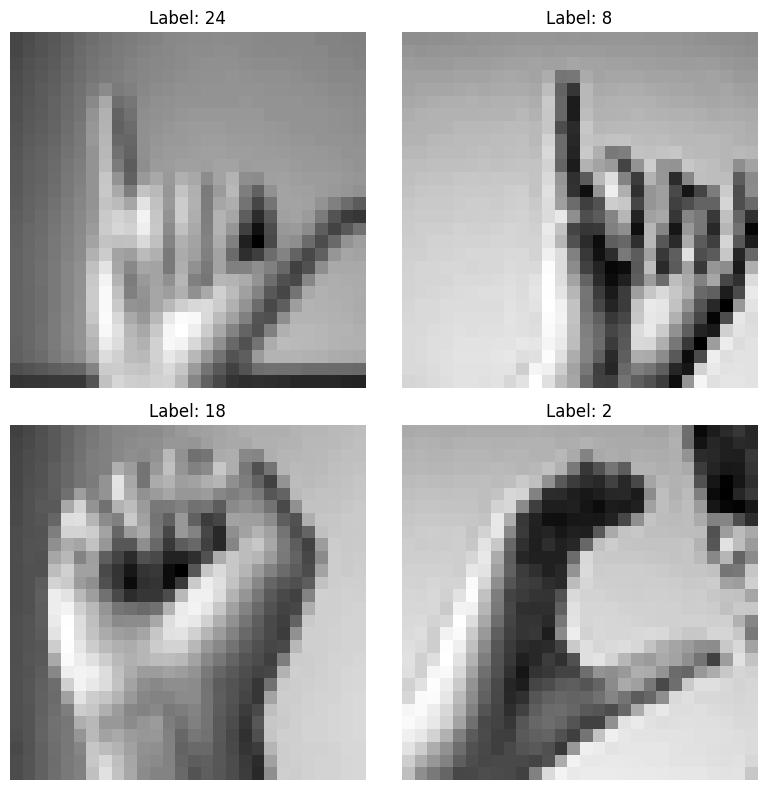

In [29]:
# Get 4 random samples from the training data
random_samples = train_df.sample(n=4, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))


for i, ax in enumerate(axes.flatten()):
    sample_row = random_samples.iloc[i]
    
    label = sample_row.iloc[0]
    
    pixels = sample_row.iloc[1:].values
    
    image = pixels.reshape(28, 28)
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
class SignMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        label = self.df.iloc[idx, 0]
        pixels = self.df.iloc[idx, 1:].values.astype('uint8')
        image = np.array(pixels).reshape((28, 28))
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

data_transform_val = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SignMNISTDataset(dataframe=train_df, transform=data_transform_train)
val_dataset = SignMNISTDataset(dataframe=validation_df, transform=data_transform_val)
test_dataset = SignMNISTDataset(dataframe=test_df_final, transform=data_transform_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

children = list(model.children())

for child in children[7:]:
    for param in child.parameters():
        param.requires_grad = True

num_ftrs = model.fc.in_features
number_of_classes = 25

model.fc = nn.Linear(num_ftrs, number_of_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
params_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

summary(model, input_size = (3, 224, 224))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14

In [32]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            dataset_size = len(dataloader.dataset)

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # ADDED: Append metrics to history lists
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
        print()

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [33]:
num_epochs = 5
trained_model, train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs
)

Epoch 1/5
------------------------------
train Loss: 0.1171 Acc: 0.9659
val Loss: 0.0033 Acc: 0.9983

Epoch 2/5
------------------------------
train Loss: 0.0249 Acc: 0.9940
val Loss: 0.0077 Acc: 0.9986

Epoch 3/5
------------------------------
train Loss: 0.0174 Acc: 0.9950
val Loss: 0.0517 Acc: 0.9829

Epoch 4/5
------------------------------
train Loss: 0.0144 Acc: 0.9959
val Loss: 0.0010 Acc: 0.9997

Epoch 5/5
------------------------------
train Loss: 0.0128 Acc: 0.9966
val Loss: 0.0034 Acc: 0.9991



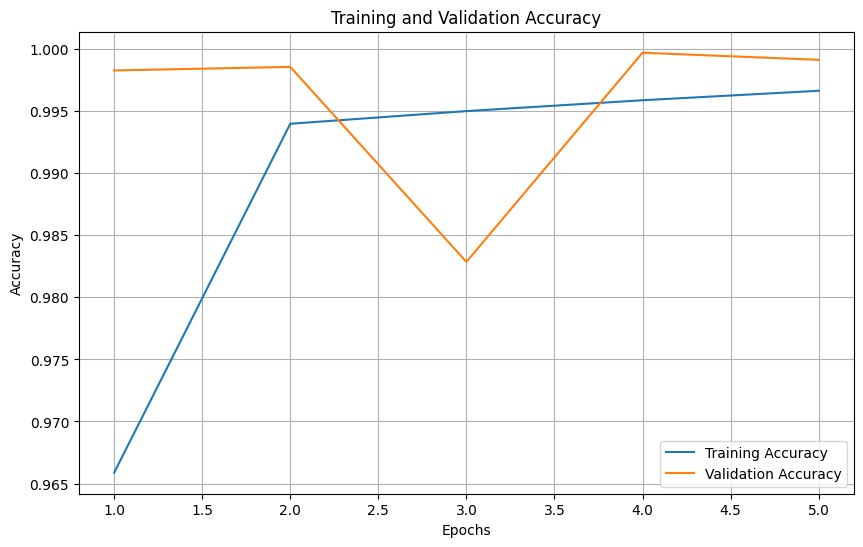

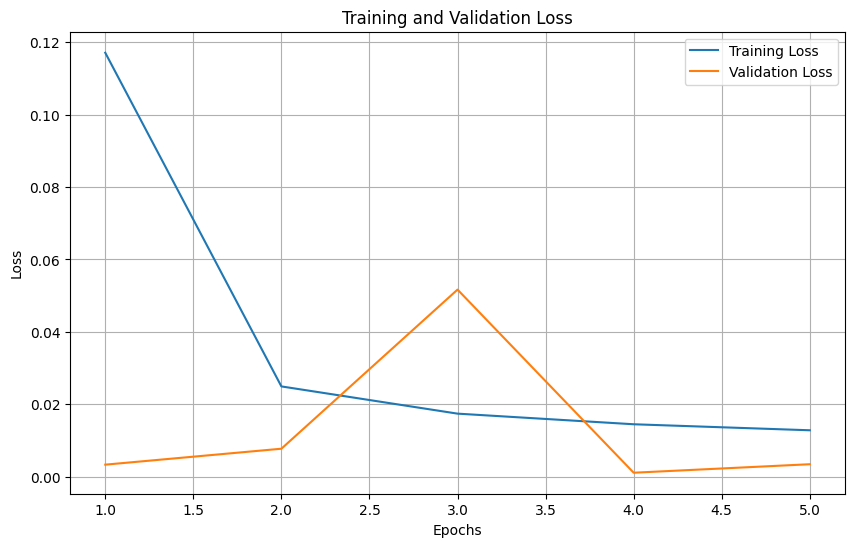

In [34]:
train_acc = [h.cpu().numpy() for h in train_acc]
val_acc = [h.cpu().numpy() for h in val_acc]

# --- Plot Accuracy ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png') # Save the plot as an image
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png') # Save the plot as an image
plt.show()

In [35]:
def get_test_predictions(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

F1 Score (Weighted): 0.9984



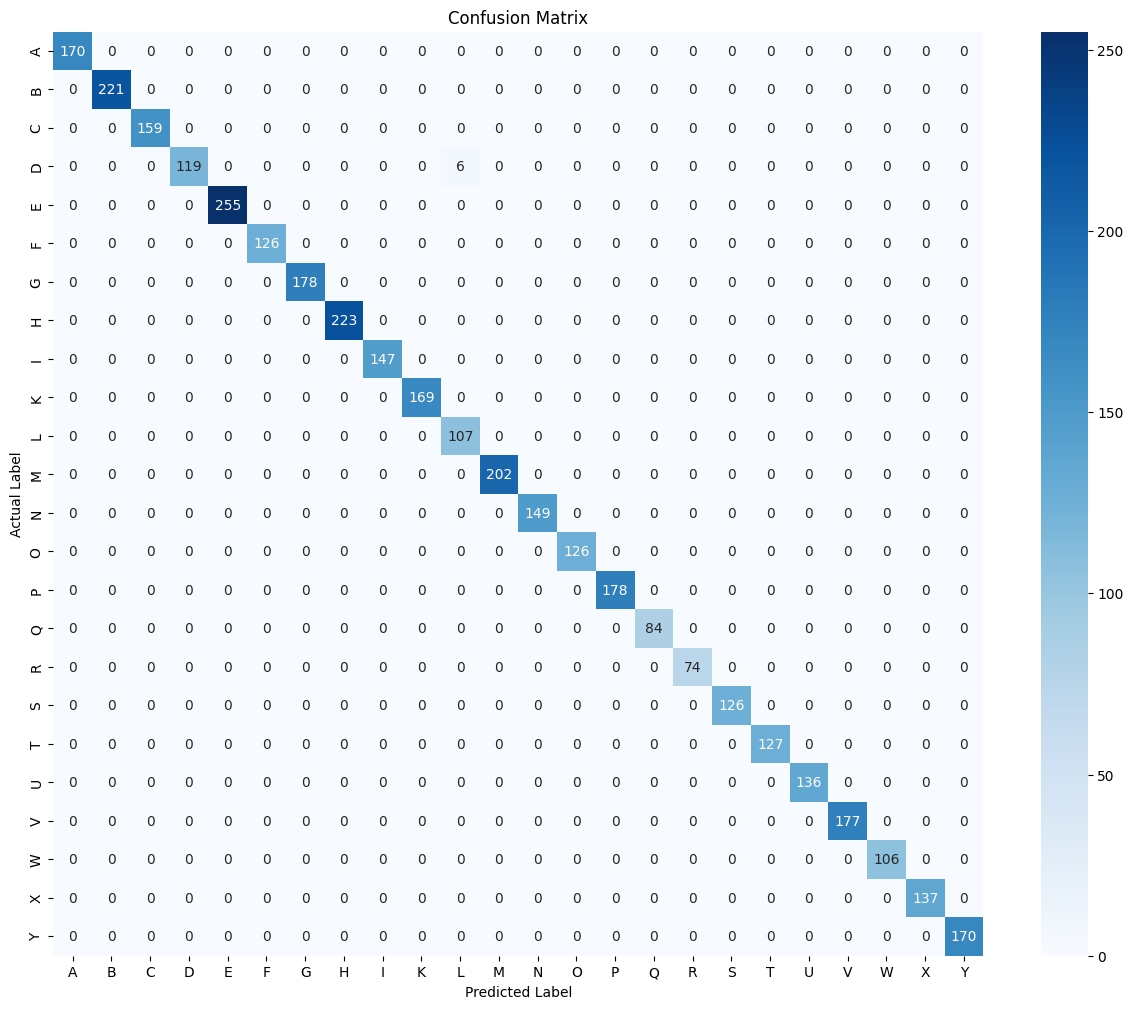

In [36]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

label_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 
    6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 
    13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
    19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}
y_true, y_pred = get_test_predictions(trained_model, test_loader)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.4f}\n")

conf_matrix = confusion_matrix(y_true, y_pred)

class_indices = sorted(label_map.keys())
class_names = [label_map[i] for i in class_indices]

plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

### Testing on local image

tensor([[  4.2152,  -2.8593,  -3.5778, -11.1914,  -8.2843,  -8.6511,   0.3112,
          -3.2195,  -5.3680,  -6.6508, -10.6562,   0.1648,  -3.9789,  -4.9301,
          -7.2822,  -4.7033,  -2.9995,  -8.2357,  -5.4794,  -4.0408,  -6.9269,
          -9.7451,  -2.1542, -10.8032,   5.2977]], device='cuda:0')


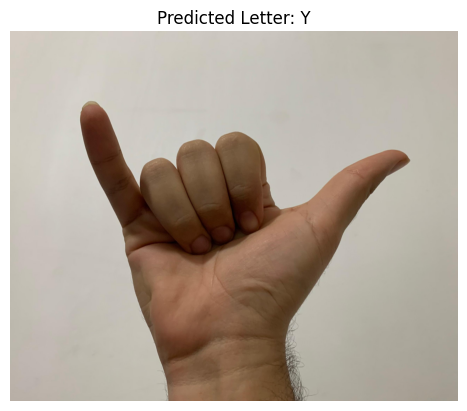

In [37]:
path_to_your_image = 'WhatsApp Image 2025-08-01 at 23.27.03_b715df5a.jpg'

trained_model.eval()

img = Image.open(path_to_your_image)


img_transformed = data_transform(img)

batch_img = img_transformed.unsqueeze(0)

batch_img = batch_img.to(device)

with torch.no_grad():
    outputs = trained_model(batch_img)
    _, preds = torch.max(outputs, 1)
    predicted_index = preds[0].item()

predicted_letter = label_map.get(predicted_index, "Unknown Class")
print(outputs)
# --- Display the image and the prediction ---
plt.imshow(img)
plt.title(f'Predicted Letter: {predicted_letter}')
plt.axis('off')
plt.show()